In [1]:
import json
import math
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple, OrderedDict
from pathlib import Path

import albumentations as A

In [2]:
sys.path.insert(0, '../src/lib')

In [3]:
from utils import car_models
from utils.geometry import create_camera_matrix, euler_angles_to_rotation_matrix, euler_angles_to_quaternions, proj_point, proj_points, calc_bbox
from utils.image import affine_transform, get_affine_transform, pad_img_sides, hflip
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.kaggle_cars_utils import parse_annot_str

In [4]:
INPUT_PATH = '../data/pku-autonomous-driving'
MODEL_DIR = os.path.join(INPUT_PATH, 'car_models_json')

In [5]:
def read_split_file(split, data_dir=INPUT_PATH):
    path = os.path.join(data_dir, 'split', split+'.txt')
    with open(path) as f:
        return [line.rstrip('\n')[:-4] for line in f]
    
    
def load_car_models(model_dir=MODEL_DIR):
    """Load all the car models
    """
    car_models_all = OrderedDict([])
    print('loading %d car models' % len(car_models.models))
    for model in car_models.models:
        car_model = '%s/%s.json' % (model_dir, model.name)
        with open(car_model) as json_file:
            car = json.load(json_file)
        for key in ['vertices', 'faces']:
            car[key] = np.array(car[key])
        # fix the inconsistency between obj and pkl
        car['vertices'][:, [0, 1]] *= -1
        car_models_all[model.name] = car 
    return car_models_all  


def imshow(img, boxes=None, figsize=(16,8)):
    plt.figure(figsize=figsize)
    ax = plt.axes()
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            plt.gca().add_patch(rect)
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())


def add_blend_img(back, fore, trans=0.7, white_theme=False):
    if white_theme:
        fore = 255 - fore
    if fore.shape[0] != back.shape[0] or fore.shape[0] != back.shape[1]:
        fore = cv2.resize(fore, (back.shape[1], back.shape[0]))
    if len(fore.shape) == 2:
        fore = fore.reshape(fore.shape[0], fore.shape[1], 1)
    out = (back * (1. - trans) + fore * trans)
    out[out > 255] = 255
    out[out < 0] = 0
    return out.astype(np.uint8).copy()

In [342]:
def car_6dof_pixel_tfms():
    noise_scale = [0.03 * 255, 0.06 * 255]
    blur_limit = [5, 11]
    
    tfms = [
        A.OneOf([
          A.RandomBrightnessContrast(
            brightness_limit=0.08, contrast_limit=0.08,
            p=1),
          A.CLAHE(p=1)
        ], p=0.3),
        A.OneOf([
          A.RandomGamma(p=1),
          A.HueSaturationValue(p=1),
        ], p=0.2),
        A.OneOf([
          A.Blur(blur_limit=blur_limit, p=1),
          A.GaussianBlur(blur_limit=blur_limit, p=1)
        ], p=0.15),
        A.IAAAdditiveGaussianNoise(scale=noise_scale, p=0.2),
    ]
    tfms = A.Compose(tfms)
    def _wrapper(image):
        return tfms(image=image)['image']
    return _wrapper

In [343]:
tfms = car_6dof_pixel_tfms()

In [435]:
noise_amt = [0.03, 0.06]
noise_amt = [v * 255 for v in noise_amt]
blur_limit = [5, 11]

tfms = [
    # A.CLAHE(p=1.0),
    # A.GaussNoise(var_limit=tuple(noise_amt), always_apply=True),
    # A.Blur(blur_limit=blur_limit, always_apply=True),
    # A.GaussianBlur(blur_limit=blur_limit, always_apply=True),
    # A.IAAAdditiveGaussianNoise(scale=noise_amt, always_apply=True),
    # A.RandomGamma(gamma_limit=(80,120), p=1),
    A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=0, val_shift_limit=0, p=1)
]
tfms = A.Compose(tfms)

def _wrapper(image):
    return tfms(image=image)['image']

(81.96694938048671, 0, 255)

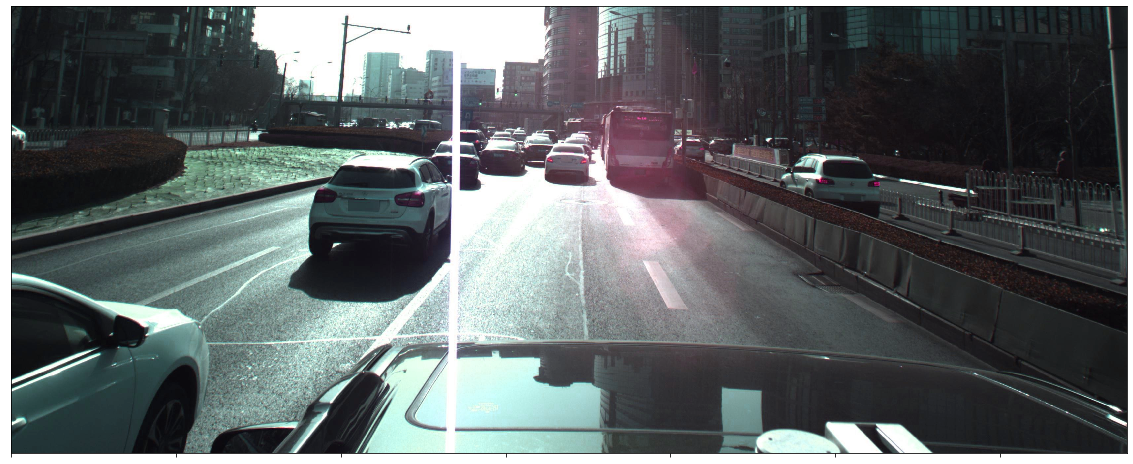

In [442]:
img_id = 'ID_0289b0bc8'
img_path = os.path.join(INPUT_PATH, 'train_images', img_id+'.jpg')
img = cv2.imread(img_path)[:,:,::-1]
y_mid = img.shape[0]//2
img = img[y_mid:]
img0 = np.copy(img)
img = _wrapper(img)
imshow(img, figsize=(20,10))

diff = img - img0
diff.mean(), diff.min(), diff.max()